In [8]:
import os
import pandas as pd

def aggregate_pred_dataframe(files):
    print(files)
    dfs = [pd.read_csv(f) for f in files]
    final_df = dfs[0].rename(columns={'pred': 'pred_0'})
    for i in range(1, len(dfs)):
        final_df[f'pred_{i}'] = dfs[i]['pred']
    return final_df.reset_index()

def get_preds_with_prefixes(prefixes, seed_start=0, seed_end=20):
    if prefixes is str:
        prefixes = [prefixes]
    csv_files = [file for file in os.listdir('preds') if file.endswith('.csv')]
    csv_files.sort()
    len(csv_files)
    preds = []
    for seed in range(seed_start, seed_end):
        for prefix in prefixes:            
            filtered = [file for file in csv_files if file.startswith(f'{prefix}_{seed:02d}_')] # get all file with same seed
            valid = [file for file in filtered if file.endswith('valid.csv')] # get valid file
            test = [file for file in filtered if file.endswith('test.csv')] # get test file
            if filtered:
                preds.append((valid[0], test[0]))
    return preds

def aggregate_preds(preds):
    df_valid = aggregate_pred_dataframe([f'preds/{i[0]}' for i in preds])
    df_test = aggregate_pred_dataframe([f'preds/{i[1]}' for i in preds])
    
    return df_valid, df_test

%matplotlib inline
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score, matthews_corrcoef
import matplotlib.pyplot as plt
import numpy as np

def round_dict(d, n):
    return {k: round(v, n) if isinstance(v, float) else v
                for k, v in d.items()}

def generate_mean_ensemble_metrics(df, threshold=0):
    sum_preds = df[list(filter(lambda a: a.startswith('pred_'), df.columns.tolist()))].mean(axis=1)
    final_prediction = (sum_preds > threshold).astype(int)

    # Sensitivity (Recall)
    sensitivity = recall_score(df['target'], final_prediction)

    # Specificity
    tn, fp, fn, tp = confusion_matrix(df['target'], final_prediction).ravel()
    specificity = tn / (tn + fp)

    # Accuracy
    accuracy = accuracy_score(df['target'], final_prediction)

    # Precision
    precision = precision_score(df['target'], final_prediction)
    mcc = matthews_corrcoef(df['target'], final_prediction)
    return {
        "sensitivity": sensitivity,
        "specificity": specificity,
        "accuracy": accuracy,
        "precision": precision,
        "mcc": mcc,
    }


def generate_hard_voting_ensemble_metrics(df, threshold=0):
    # Convert the float predictions to binary labels using the given threshold
    binary_preds = df[list(filter(lambda a: a.startswith('pred_'), df.columns.tolist()))] > threshold

    # Count the number of times a particular class (1 in this case) is predicted for each row
    vote_sum = binary_preds.sum(axis=1)
    
    # Decide the final prediction based on majority vote
    n_models = len(list(filter(lambda a: a.startswith('pred_'), df.columns.tolist())))
    final_prediction = (vote_sum > n_models / 2).astype(int)

    # Sensitivity (Recall)
    sensitivity = recall_score(df['target'], final_prediction)

    # Specificity
    tn, fp, fn, tp = confusion_matrix(df['target'], final_prediction).ravel()
    specificity = tn / (tn + fp)

    # Accuracy
    accuracy = accuracy_score(df['target'], final_prediction)

    # Precision
    precision = precision_score(df['target'], final_prediction)
    mcc = matthews_corrcoef(df['target'], final_prediction)
    return {
        "sensitivity": sensitivity,
        "specificity": specificity,
        "accuracy": accuracy,
        "precision": precision,
        "mcc": mcc,
    }
    
def draw_mean_ensemble_thrshold_chart(df_valid, df_test, start=-3, end=1, step=0.1,
                                      plot=True):
    # Create a list of thresholds to test
    thresholds = np.arange(start, end, step)  # Adjust the step size as necessary
    valid_mccs = []
    test_metrics = []

    # Loop through thresholds and compute MCC
    for threshold in thresholds:
        metrics = generate_mean_ensemble_metrics(df_valid, threshold)
        valid_mccs.append(metrics['mcc'])
        
        metrics_test = generate_mean_ensemble_metrics(df_test, threshold)
        test_metrics.append(metrics_test)

    # Identify threshold with the best MCC
    best_threshold_arg = np.argmax(valid_mccs)
    best_threshold = thresholds[best_threshold_arg]

    label = f'Best Threshold: {best_threshold:.1f}, Valid MCC: {valid_mccs[best_threshold_arg]:.3f}, Test MCC: {test_metrics[best_threshold_arg]["mcc"]:.3f}'
    # Plot
    if plot:
        plt.figure(figsize=(10, 6))
        plt.plot(thresholds, valid_mccs, label='Valid MCC', color='blue')
        plt.plot(thresholds, [i['mcc'] for i in test_metrics], label='Test MCC', color='green')
        plt.axvline(x=best_threshold, color='red', linestyle='--', label=label)
        plt.xlabel('Threshold')
        plt.ylabel('MCC Value')
        plt.title('MCC vs. Threshold')
        plt.legend()
        plt.grid(True)
        plt.show()
    return {
        'best_threshold': best_threshold, 
        'valid_mcc': valid_mccs[best_threshold_arg],
        **test_metrics[best_threshold_arg]
    }

def draw_hard_voting_threshold_chart(df_valid, df_test, start=-3, end=1, step=0.1,
                                      plot=True):
    # Create a list of thresholds to test
    thresholds = np.arange(start, end, step)  # Adjust the step size as necessary
    valid_mccs = []
    test_metrics = []

    # Loop through thresholds and compute MCC
    for threshold in thresholds:
        metrics = generate_hard_voting_ensemble_metrics(df_valid, threshold)
        valid_mccs.append(metrics['mcc'])
        
        metrics_test = generate_hard_voting_ensemble_metrics(df_test, threshold)
        test_metrics.append(metrics_test)

    # Identify threshold with the best MCC
    best_threshold_arg = np.argmax(valid_mccs)
    best_threshold = thresholds[best_threshold_arg]

    label = f'Best Threshold: {best_threshold:.1f}, Valid MCC: {valid_mccs[best_threshold_arg]:.3f}, Test MCC: {test_metrics[best_threshold_arg]["mcc"]:.3f}'
    # Plot
    if plot:
        plt.figure(figsize=(10, 6))
        plt.plot(thresholds, valid_mccs, label='Valid MCC', color='blue')
        plt.plot(thresholds, [i['mcc'] for i in test_metrics], label='Test MCC', color='green')
        plt.axvline(x=best_threshold, color='red', linestyle='--', label=label)
        plt.xlabel('Threshold')
        plt.ylabel('MCC Value')
        plt.title('MCC vs. Threshold')
        plt.legend()
        plt.grid(True)
        plt.show()
    return {
        'best_threshold': best_threshold, 
        'valid_mcc': valid_mccs[best_threshold_arg],
        **test_metrics[best_threshold_arg]
    }


def random_small_ensembles(preds, n, trial, start=-3, end=1, step=0.1):
    from random import sample
    df = pd.DataFrame()
    for i in range(trial):
        sample_preds = sample(preds, n)
        df_valid = aggregate_pred_dataframe([f'preds/{i[0]}' for i in sample_preds])
        df_test = aggregate_pred_dataframe([f'preds/{i[1]}' for i in sample_preds])


        new_row = [draw_mean_ensemble_thrshold_chart(df_valid, df_test, start=start, end=end, step=step, plot=False)]
        new_df = pd.DataFrame(new_row)
        df = pd.concat([df, new_df], ignore_index=True)

    return df


def summarize_prefix(prefixes, n, plot=False, start=-3, end=1, step=0.1, apply_sig=False, seed_start=0, seed_end=20):
    preds = get_preds_with_prefixes(prefixes, seed_start=seed_start, seed_end=seed_end)
    df_valid, df_test = aggregate_preds(preds)
    print(f'Ensemble of all {len(preds)} models:')
    
    if apply_sig:
        def sigmoid(x):
            return 1 / (1 + np.exp(-x))
        # Apply the sigmoid function to all pred columns
        pred_columns = df_valid.filter(like='pred_').columns
        df_valid[pred_columns] = df_valid[pred_columns].apply(sigmoid)
        df_test[pred_columns] = df_test[pred_columns].apply(sigmoid)
    print(round_dict(draw_mean_ensemble_thrshold_chart(df_valid, df_test, start=start, end=end, step=step, plot=plot), 4))

    print(f'Ensemble of {n} random models:')
    df = random_small_ensembles(preds, n, 10, start=start, end=end, step=step)
    return df.aggregate(['mean', 'std', 'max']).T.round(3)


['preds/adaboost_00_valid.csv', 'preds/adaboost_01_valid.csv', 'preds/adaboost_02_valid.csv', 'preds/adaboost_03_valid.csv', 'preds/adaboost_04_valid.csv', 'preds/adaboost_05_valid.csv', 'preds/adaboost_06_valid.csv', 'preds/adaboost_07_valid.csv', 'preds/adaboost_08_valid.csv', 'preds/adaboost_09_valid.csv', 'preds/adaboost_10_valid.csv', 'preds/adaboost_11_valid.csv', 'preds/adaboost_12_valid.csv', 'preds/adaboost_13_valid.csv', 'preds/adaboost_14_valid.csv', 'preds/adaboost_15_valid.csv', 'preds/adaboost_16_valid.csv', 'preds/adaboost_17_valid.csv', 'preds/adaboost_18_valid.csv', 'preds/adaboost_19_valid.csv', 'preds/adaboost_20_valid.csv', 'preds/adaboost_21_valid.csv', 'preds/adaboost_22_valid.csv', 'preds/adaboost_23_valid.csv', 'preds/adaboost_24_valid.csv', 'preds/adaboost_25_valid.csv', 'preds/adaboost_26_valid.csv', 'preds/adaboost_27_valid.csv', 'preds/adaboost_28_valid.csv', 'preds/adaboost_29_valid.csv']
['preds/adaboost_00_test.csv', 'preds/adaboost_01_test.csv', 'preds/a

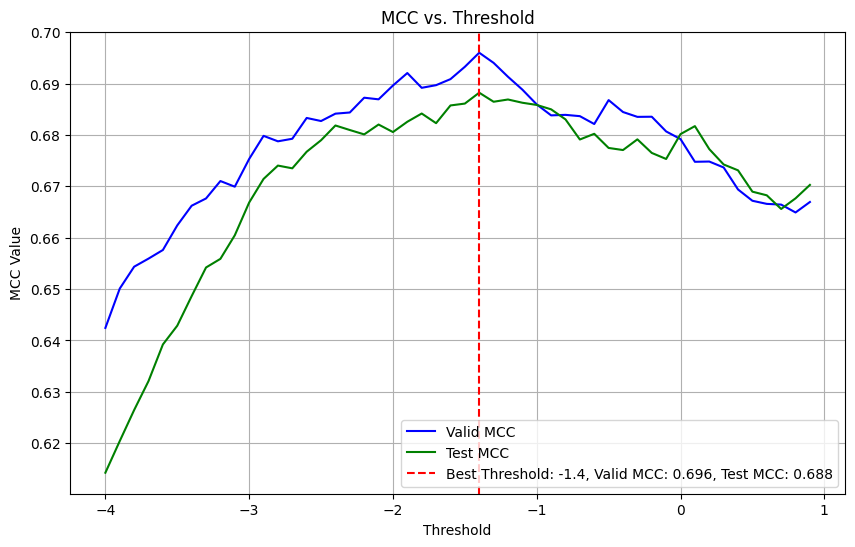

{'best_threshold': -1.4, 'valid_mcc': 0.696, 'sensitivity': 0.681, 'specificity': 0.9861, 'accuracy': 0.9703, 'precision': 0.7274, 'mcc': 0.6882}
Ensemble of 10 random models:
['preds/adaboost_08_valid.csv', 'preds/adaboost_09_valid.csv', 'preds/adaboost_24_valid.csv', 'preds/adaboost_27_valid.csv', 'preds/adaboost_02_valid.csv', 'preds/adaboost_21_valid.csv', 'preds/adaboost_15_valid.csv', 'preds/adaboost_01_valid.csv', 'preds/adaboost_06_valid.csv', 'preds/adaboost_12_valid.csv']
['preds/adaboost_08_test.csv', 'preds/adaboost_09_test.csv', 'preds/adaboost_24_test.csv', 'preds/adaboost_27_test.csv', 'preds/adaboost_02_test.csv', 'preds/adaboost_21_test.csv', 'preds/adaboost_15_test.csv', 'preds/adaboost_01_test.csv', 'preds/adaboost_06_test.csv', 'preds/adaboost_12_test.csv']
['preds/adaboost_01_valid.csv', 'preds/adaboost_29_valid.csv', 'preds/adaboost_17_valid.csv', 'preds/adaboost_24_valid.csv', 'preds/adaboost_20_valid.csv', 'preds/adaboost_26_valid.csv', 'preds/adaboost_14_valid.

,mean,std,max
best_threshold,-1.540,0.552,-0.800
valid_mcc,0.689,0.006,0.698
sensitivity,0.684,0.021,0.715
specificity,0.985,0.002,0.987
accuracy,0.969,0.001,0.970
precision,0.711,0.020,0.740
mcc,0.681,0.004,0.686


In [2]:
summarize_prefix(['adaboost'], 10, plot=True, start=-4, end=1, step=0.1, seed_start=0, seed_end=30)

['preds/adaboost_00_valid.csv', 'preds/adaboost_01_valid.csv', 'preds/adaboost_02_valid.csv', 'preds/adaboost_03_valid.csv', 'preds/adaboost_04_valid.csv', 'preds/adaboost_05_valid.csv', 'preds/adaboost_06_valid.csv', 'preds/adaboost_07_valid.csv', 'preds/adaboost_08_valid.csv', 'preds/adaboost_09_valid.csv', 'preds/adaboost_10_valid.csv', 'preds/adaboost_11_valid.csv', 'preds/adaboost_12_valid.csv', 'preds/adaboost_13_valid.csv', 'preds/adaboost_14_valid.csv']
['preds/adaboost_00_test.csv', 'preds/adaboost_01_test.csv', 'preds/adaboost_02_test.csv', 'preds/adaboost_03_test.csv', 'preds/adaboost_04_test.csv', 'preds/adaboost_05_test.csv', 'preds/adaboost_06_test.csv', 'preds/adaboost_07_test.csv', 'preds/adaboost_08_test.csv', 'preds/adaboost_09_test.csv', 'preds/adaboost_10_test.csv', 'preds/adaboost_11_test.csv', 'preds/adaboost_12_test.csv', 'preds/adaboost_13_test.csv', 'preds/adaboost_14_test.csv']
Ensemble of all 15 models:


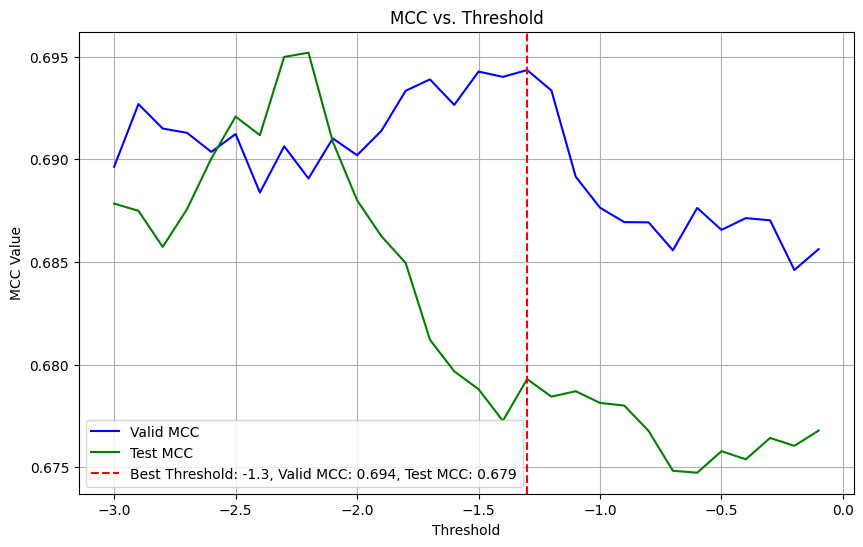

{'best_threshold': -1.3, 'valid_mcc': 0.6943, 'sensitivity': 0.6507, 'specificity': 0.9876, 'accuracy': 0.9702, 'precision': 0.7418, 'mcc': 0.6793}
Ensemble of 10 random models:
['preds/adaboost_10_valid.csv', 'preds/adaboost_04_valid.csv', 'preds/adaboost_06_valid.csv', 'preds/adaboost_05_valid.csv', 'preds/adaboost_13_valid.csv', 'preds/adaboost_12_valid.csv', 'preds/adaboost_03_valid.csv', 'preds/adaboost_01_valid.csv', 'preds/adaboost_08_valid.csv', 'preds/adaboost_07_valid.csv']
['preds/adaboost_10_test.csv', 'preds/adaboost_04_test.csv', 'preds/adaboost_06_test.csv', 'preds/adaboost_05_test.csv', 'preds/adaboost_13_test.csv', 'preds/adaboost_12_test.csv', 'preds/adaboost_03_test.csv', 'preds/adaboost_01_test.csv', 'preds/adaboost_08_test.csv', 'preds/adaboost_07_test.csv']
['preds/adaboost_01_valid.csv', 'preds/adaboost_05_valid.csv', 'preds/adaboost_10_valid.csv', 'preds/adaboost_07_valid.csv', 'preds/adaboost_06_valid.csv', 'preds/adaboost_00_valid.csv', 'preds/adaboost_03_vali

,mean,std,max
best_threshold,-1.990,0.692,-0.800
valid_mcc,0.693,0.002,0.694
sensitivity,0.676,0.023,0.711
specificity,0.986,0.002,0.988
accuracy,0.970,0.001,0.971
precision,0.721,0.023,0.752
mcc,0.682,0.003,0.690


In [3]:
summarize_prefix(['adaboost'], 10, plot=True, start=-3, end=0, step=0.1, seed_start=0, seed_end=15)

['preds/adaboost_15_valid.csv', 'preds/adaboost_16_valid.csv', 'preds/adaboost_17_valid.csv', 'preds/adaboost_18_valid.csv', 'preds/adaboost_19_valid.csv', 'preds/adaboost_20_valid.csv', 'preds/adaboost_21_valid.csv', 'preds/adaboost_22_valid.csv', 'preds/adaboost_23_valid.csv', 'preds/adaboost_24_valid.csv', 'preds/adaboost_25_valid.csv', 'preds/adaboost_26_valid.csv', 'preds/adaboost_27_valid.csv', 'preds/adaboost_28_valid.csv', 'preds/adaboost_29_valid.csv']
['preds/adaboost_15_test.csv', 'preds/adaboost_16_test.csv', 'preds/adaboost_17_test.csv', 'preds/adaboost_18_test.csv', 'preds/adaboost_19_test.csv', 'preds/adaboost_20_test.csv', 'preds/adaboost_21_test.csv', 'preds/adaboost_22_test.csv', 'preds/adaboost_23_test.csv', 'preds/adaboost_24_test.csv', 'preds/adaboost_25_test.csv', 'preds/adaboost_26_test.csv', 'preds/adaboost_27_test.csv', 'preds/adaboost_28_test.csv', 'preds/adaboost_29_test.csv']
Ensemble of all 15 models:


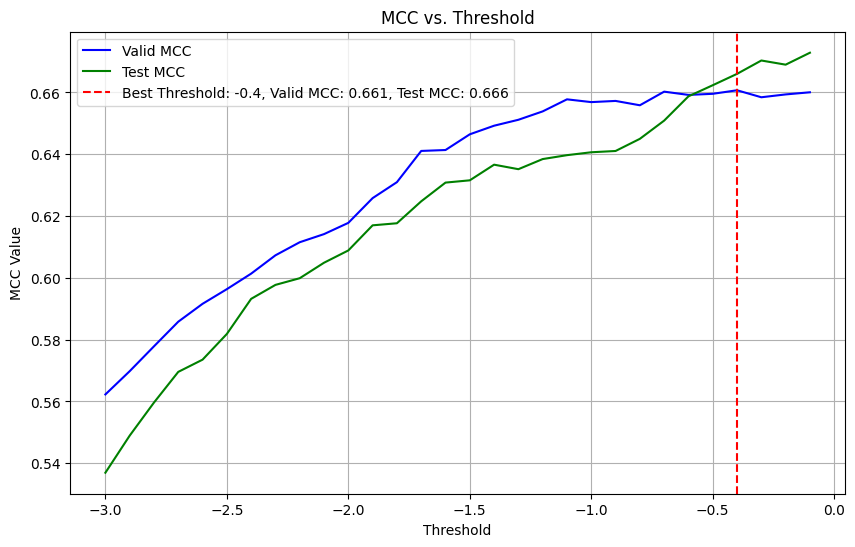

{'best_threshold': -0.4, 'valid_mcc': 0.6607, 'sensitivity': 0.6507, 'specificity': 0.9859, 'accuracy': 0.9685, 'precision': 0.7158, 'mcc': 0.666}
Ensemble of 10 random models:
['preds/adaboost_27_valid.csv', 'preds/adaboost_26_valid.csv', 'preds/adaboost_24_valid.csv', 'preds/adaboost_20_valid.csv', 'preds/adaboost_28_valid.csv', 'preds/adaboost_23_valid.csv', 'preds/adaboost_29_valid.csv', 'preds/adaboost_16_valid.csv', 'preds/adaboost_17_valid.csv', 'preds/adaboost_22_valid.csv']
['preds/adaboost_27_test.csv', 'preds/adaboost_26_test.csv', 'preds/adaboost_24_test.csv', 'preds/adaboost_20_test.csv', 'preds/adaboost_28_test.csv', 'preds/adaboost_23_test.csv', 'preds/adaboost_29_test.csv', 'preds/adaboost_16_test.csv', 'preds/adaboost_17_test.csv', 'preds/adaboost_22_test.csv']
['preds/adaboost_18_valid.csv', 'preds/adaboost_27_valid.csv', 'preds/adaboost_22_valid.csv', 'preds/adaboost_28_valid.csv', 'preds/adaboost_21_valid.csv', 'preds/adaboost_24_valid.csv', 'preds/adaboost_29_valid

,mean,std,max
best_threshold,-0.320,0.266,-0.100
valid_mcc,0.661,0.008,0.672
sensitivity,0.647,0.021,0.687
specificity,0.985,0.002,0.989
accuracy,0.968,0.001,0.970
precision,0.710,0.027,0.758
mcc,0.661,0.006,0.668


In [4]:
summarize_prefix(['adaboost'], 10, plot=True, start=-3, end=0, step=0.1, seed_start=15, seed_end=30)

['preds/ab_me_00_valid.csv', 'preds/ab_me_01_valid.csv', 'preds/ab_me_02_valid.csv', 'preds/ab_me_03_valid.csv', 'preds/ab_me_04_valid.csv', 'preds/ab_me_05_valid.csv', 'preds/ab_me_06_valid.csv', 'preds/ab_me_07_valid.csv', 'preds/ab_me_08_valid.csv', 'preds/ab_me_09_valid.csv', 'preds/ab_me_10_valid.csv', 'preds/ab_me_11_valid.csv', 'preds/ab_me_12_valid.csv', 'preds/ab_me_13_valid.csv', 'preds/ab_me_14_valid.csv', 'preds/ab_me_15_valid.csv', 'preds/ab_me_16_valid.csv', 'preds/ab_me_17_valid.csv', 'preds/ab_me_18_valid.csv', 'preds/ab_me_19_valid.csv', 'preds/ab_me_20_valid.csv', 'preds/ab_me_21_valid.csv', 'preds/ab_me_22_valid.csv', 'preds/ab_me_23_valid.csv', 'preds/ab_me_24_valid.csv', 'preds/ab_me_25_valid.csv', 'preds/ab_me_26_valid.csv', 'preds/ab_me_27_valid.csv', 'preds/ab_me_28_valid.csv', 'preds/ab_me_29_valid.csv']
['preds/ab_me_00_test.csv', 'preds/ab_me_01_test.csv', 'preds/ab_me_02_test.csv', 'preds/ab_me_03_test.csv', 'preds/ab_me_04_test.csv', 'preds/ab_me_05_test.cs

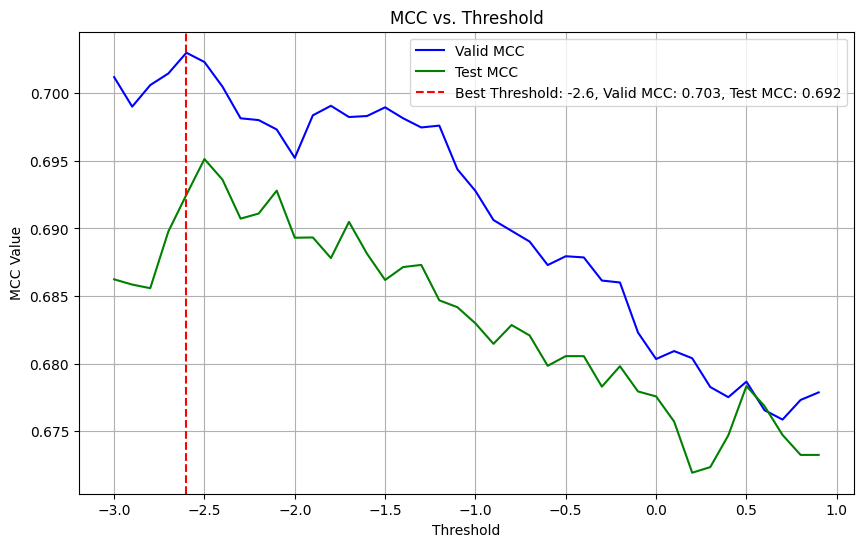

{'best_threshold': -2.6, 'valid_mcc': 0.703, 'sensitivity': 0.7049, 'specificity': 0.9844, 'accuracy': 0.9699, 'precision': 0.7118, 'mcc': 0.6925}
Ensemble of 10 random models:
['preds/ab_me_03_valid.csv', 'preds/ab_me_14_valid.csv', 'preds/ab_me_06_valid.csv', 'preds/ab_me_19_valid.csv', 'preds/ab_me_21_valid.csv', 'preds/ab_me_04_valid.csv', 'preds/ab_me_07_valid.csv', 'preds/ab_me_12_valid.csv', 'preds/ab_me_20_valid.csv', 'preds/ab_me_10_valid.csv']
['preds/ab_me_03_test.csv', 'preds/ab_me_14_test.csv', 'preds/ab_me_06_test.csv', 'preds/ab_me_19_test.csv', 'preds/ab_me_21_test.csv', 'preds/ab_me_04_test.csv', 'preds/ab_me_07_test.csv', 'preds/ab_me_12_test.csv', 'preds/ab_me_20_test.csv', 'preds/ab_me_10_test.csv']
['preds/ab_me_10_valid.csv', 'preds/ab_me_16_valid.csv', 'preds/ab_me_28_valid.csv', 'preds/ab_me_13_valid.csv', 'preds/ab_me_00_valid.csv', 'preds/ab_me_26_valid.csv', 'preds/ab_me_14_valid.csv', 'preds/ab_me_17_valid.csv', 'preds/ab_me_11_valid.csv', 'preds/ab_me_21_va

,mean,std,max
best_threshold,-2.150,0.684,-0.800
valid_mcc,0.698,0.003,0.704
sensitivity,0.681,0.024,0.710
specificity,0.986,0.002,0.990
accuracy,0.970,0.001,0.971
precision,0.721,0.023,0.769
mcc,0.685,0.006,0.693


In [5]:
summarize_prefix(['ab_me'], 10, plot=True, start=-3, end=1, step=0.1, seed_start=0, seed_end=30)

['preds/ab_me_70_00_valid.csv', 'preds/ab_me_70_01_valid.csv', 'preds/ab_me_70_02_valid.csv', 'preds/ab_me_70_03_valid.csv', 'preds/ab_me_70_04_valid.csv', 'preds/ab_me_70_05_valid.csv', 'preds/ab_me_70_06_valid.csv', 'preds/ab_me_70_07_valid.csv', 'preds/ab_me_70_08_valid.csv', 'preds/ab_me_70_09_valid.csv', 'preds/ab_me_70_10_valid.csv', 'preds/ab_me_70_11_valid.csv', 'preds/ab_me_70_12_valid.csv', 'preds/ab_me_70_13_valid.csv', 'preds/ab_me_70_14_valid.csv', 'preds/ab_me_70_15_valid.csv', 'preds/ab_me_70_16_valid.csv', 'preds/ab_me_70_17_valid.csv', 'preds/ab_me_70_18_valid.csv', 'preds/ab_me_70_19_valid.csv', 'preds/ab_me_70_20_valid.csv', 'preds/ab_me_70_21_valid.csv', 'preds/ab_me_70_22_valid.csv', 'preds/ab_me_70_23_valid.csv', 'preds/ab_me_70_24_valid.csv', 'preds/ab_me_70_25_valid.csv', 'preds/ab_me_70_26_valid.csv', 'preds/ab_me_70_27_valid.csv', 'preds/ab_me_70_28_valid.csv', 'preds/ab_me_70_29_valid.csv']
['preds/ab_me_70_00_test.csv', 'preds/ab_me_70_01_test.csv', 'preds/a

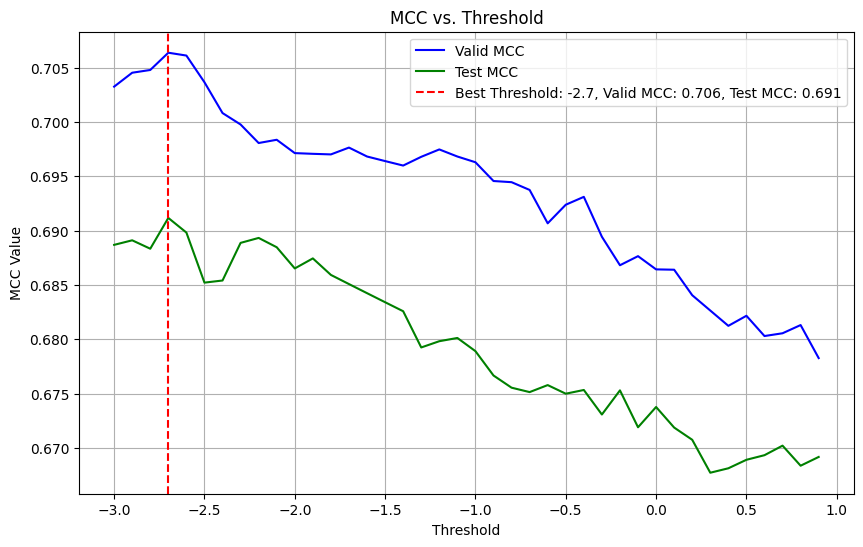

{'best_threshold': -2.7, 'valid_mcc': 0.7064, 'sensitivity': 0.6938, 'specificity': 0.9853, 'accuracy': 0.9702, 'precision': 0.7202, 'mcc': 0.6912}
Ensemble of 10 random models:
['preds/ab_me_70_14_valid.csv', 'preds/ab_me_70_18_valid.csv', 'preds/ab_me_70_23_valid.csv', 'preds/ab_me_70_19_valid.csv', 'preds/ab_me_70_09_valid.csv', 'preds/ab_me_70_12_valid.csv', 'preds/ab_me_70_05_valid.csv', 'preds/ab_me_70_11_valid.csv', 'preds/ab_me_70_17_valid.csv', 'preds/ab_me_70_20_valid.csv']
['preds/ab_me_70_14_test.csv', 'preds/ab_me_70_18_test.csv', 'preds/ab_me_70_23_test.csv', 'preds/ab_me_70_19_test.csv', 'preds/ab_me_70_09_test.csv', 'preds/ab_me_70_12_test.csv', 'preds/ab_me_70_05_test.csv', 'preds/ab_me_70_11_test.csv', 'preds/ab_me_70_17_test.csv', 'preds/ab_me_70_20_test.csv']
['preds/ab_me_70_23_valid.csv', 'preds/ab_me_70_18_valid.csv', 'preds/ab_me_70_22_valid.csv', 'preds/ab_me_70_20_valid.csv', 'preds/ab_me_70_10_valid.csv', 'preds/ab_me_70_27_valid.csv', 'preds/ab_me_70_11_vali

,mean,std,max
best_threshold,-2.260,0.617,-1.400
valid_mcc,0.700,0.002,0.703
sensitivity,0.674,0.018,0.699
specificity,0.986,0.002,0.989
accuracy,0.970,0.001,0.971
precision,0.730,0.019,0.760
mcc,0.686,0.004,0.693


In [6]:
summarize_prefix(['ab_me_70'], 10, plot=True, start=-3, end=1, step=0.1, seed_start=0, seed_end=30)

['preds/ab_me_90_00_valid.csv', 'preds/ab_me_90_01_valid.csv', 'preds/ab_me_90_02_valid.csv', 'preds/ab_me_90_03_valid.csv', 'preds/ab_me_90_04_valid.csv', 'preds/ab_me_90_05_valid.csv', 'preds/ab_me_90_06_valid.csv', 'preds/ab_me_90_07_valid.csv', 'preds/ab_me_90_08_valid.csv', 'preds/ab_me_90_09_valid.csv', 'preds/ab_me_90_10_valid.csv', 'preds/ab_me_90_11_valid.csv', 'preds/ab_me_90_12_valid.csv', 'preds/ab_me_90_13_valid.csv', 'preds/ab_me_90_14_valid.csv', 'preds/ab_me_90_15_valid.csv', 'preds/ab_me_90_16_valid.csv', 'preds/ab_me_90_17_valid.csv', 'preds/ab_me_90_18_valid.csv', 'preds/ab_me_90_19_valid.csv', 'preds/ab_me_90_20_valid.csv', 'preds/ab_me_90_21_valid.csv', 'preds/ab_me_90_22_valid.csv', 'preds/ab_me_90_23_valid.csv', 'preds/ab_me_90_24_valid.csv', 'preds/ab_me_90_25_valid.csv', 'preds/ab_me_90_26_valid.csv', 'preds/ab_me_90_27_valid.csv', 'preds/ab_me_90_28_valid.csv', 'preds/ab_me_90_29_valid.csv']
['preds/ab_me_90_00_test.csv', 'preds/ab_me_90_01_test.csv', 'preds/a

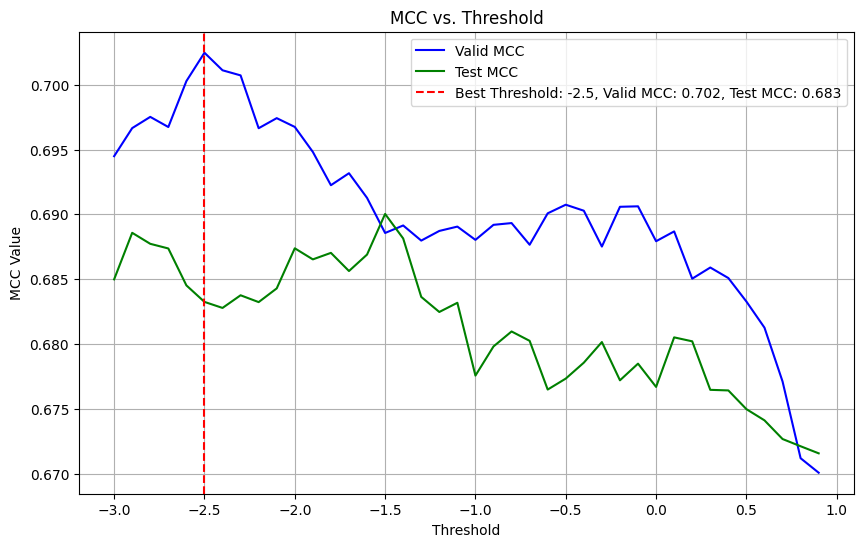

{'best_threshold': -2.5, 'valid_mcc': 0.7025, 'sensitivity': 0.6922, 'specificity': 0.9843, 'accuracy': 0.9692, 'precision': 0.7068, 'mcc': 0.6832}
Ensemble of 10 random models:
['preds/ab_me_90_27_valid.csv', 'preds/ab_me_90_08_valid.csv', 'preds/ab_me_90_21_valid.csv', 'preds/ab_me_90_01_valid.csv', 'preds/ab_me_90_20_valid.csv', 'preds/ab_me_90_07_valid.csv', 'preds/ab_me_90_16_valid.csv', 'preds/ab_me_90_14_valid.csv', 'preds/ab_me_90_02_valid.csv', 'preds/ab_me_90_23_valid.csv']
['preds/ab_me_90_27_test.csv', 'preds/ab_me_90_08_test.csv', 'preds/ab_me_90_21_test.csv', 'preds/ab_me_90_01_test.csv', 'preds/ab_me_90_20_test.csv', 'preds/ab_me_90_07_test.csv', 'preds/ab_me_90_16_test.csv', 'preds/ab_me_90_14_test.csv', 'preds/ab_me_90_02_test.csv', 'preds/ab_me_90_23_test.csv']
['preds/ab_me_90_17_valid.csv', 'preds/ab_me_90_04_valid.csv', 'preds/ab_me_90_03_valid.csv', 'preds/ab_me_90_14_valid.csv', 'preds/ab_me_90_10_valid.csv', 'preds/ab_me_90_02_valid.csv', 'preds/ab_me_90_21_vali

,mean,std,max
best_threshold,-1.950,0.392,-1.400
valid_mcc,0.696,0.003,0.702
sensitivity,0.674,0.026,0.715
specificity,0.985,0.002,0.989
accuracy,0.969,0.001,0.970
precision,0.718,0.023,0.756
mcc,0.679,0.006,0.690


In [7]:
summarize_prefix(['ab_me_90'], 10, plot=True, start=-3, end=1, step=0.1, seed_start=0, seed_end=30)

['preds/ab_me_70_00_valid.csv', 'preds/ab_me_70_01_valid.csv', 'preds/ab_me_70_02_valid.csv', 'preds/ab_me_70_03_valid.csv', 'preds/ab_me_70_04_valid.csv', 'preds/ab_me_70_05_valid.csv', 'preds/ab_me_70_06_valid.csv', 'preds/ab_me_70_07_valid.csv', 'preds/ab_me_70_08_valid.csv', 'preds/ab_me_70_09_valid.csv', 'preds/ab_me_70_10_valid.csv', 'preds/ab_me_70_11_valid.csv', 'preds/ab_me_70_12_valid.csv', 'preds/ab_me_70_13_valid.csv', 'preds/ab_me_70_14_valid.csv', 'preds/ab_me_70_15_valid.csv', 'preds/ab_me_70_16_valid.csv', 'preds/ab_me_70_17_valid.csv', 'preds/ab_me_70_18_valid.csv', 'preds/ab_me_70_19_valid.csv', 'preds/ab_me_70_20_valid.csv', 'preds/ab_me_70_21_valid.csv', 'preds/ab_me_70_22_valid.csv', 'preds/ab_me_70_23_valid.csv', 'preds/ab_me_70_24_valid.csv', 'preds/ab_me_70_25_valid.csv', 'preds/ab_me_70_26_valid.csv', 'preds/ab_me_70_27_valid.csv', 'preds/ab_me_70_28_valid.csv', 'preds/ab_me_70_29_valid.csv']
['preds/ab_me_70_00_test.csv', 'preds/ab_me_70_01_test.csv', 'preds/a

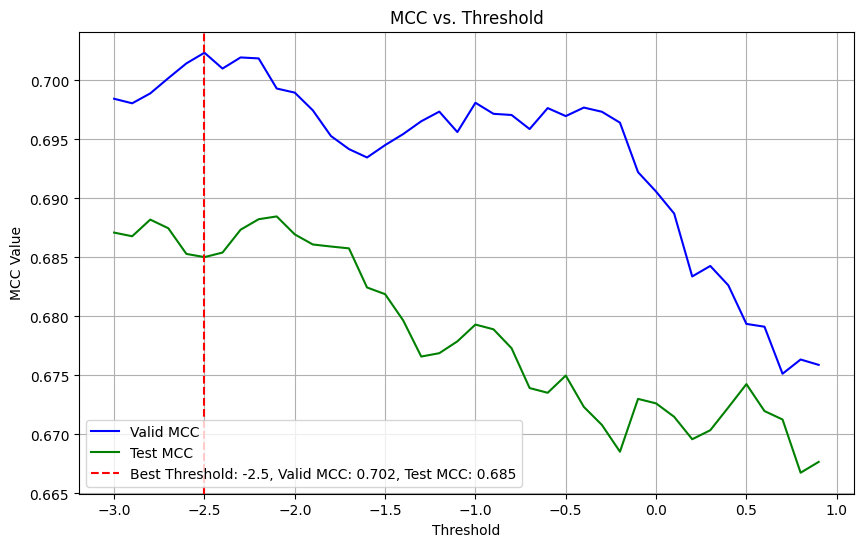

{'best_threshold': -2.4999999999999996,
 'valid_mcc': 0.7023474588510722,
 'sensitivity': 0.6810207336523126,
 'specificity': 0.9856259256032756,
 'accuracy': 0.9698496613249629,
 'precision': 0.7212837837837838,
 'mcc': 0.685026763701699}

In [14]:
preds = get_preds_with_prefixes(['ab_me_70'], seed_start=0, seed_end=30)
df_valid, df_test = aggregate_preds(preds)

draw_hard_voting_threshold_chart(df_valid, df_test, start=-3, end=1, step=0.1, plot=True)

['preds/ab_me_90_00_valid.csv', 'preds/ab_me_90_01_valid.csv', 'preds/ab_me_90_02_valid.csv', 'preds/ab_me_90_03_valid.csv', 'preds/ab_me_90_04_valid.csv', 'preds/ab_me_90_05_valid.csv', 'preds/ab_me_90_06_valid.csv', 'preds/ab_me_90_07_valid.csv', 'preds/ab_me_90_08_valid.csv', 'preds/ab_me_90_09_valid.csv', 'preds/ab_me_90_10_valid.csv', 'preds/ab_me_90_11_valid.csv', 'preds/ab_me_90_12_valid.csv', 'preds/ab_me_90_13_valid.csv', 'preds/ab_me_90_14_valid.csv', 'preds/ab_me_90_15_valid.csv', 'preds/ab_me_90_16_valid.csv', 'preds/ab_me_90_17_valid.csv', 'preds/ab_me_90_18_valid.csv', 'preds/ab_me_90_19_valid.csv', 'preds/ab_me_90_20_valid.csv', 'preds/ab_me_90_21_valid.csv', 'preds/ab_me_90_22_valid.csv', 'preds/ab_me_90_23_valid.csv', 'preds/ab_me_90_24_valid.csv', 'preds/ab_me_90_25_valid.csv', 'preds/ab_me_90_26_valid.csv', 'preds/ab_me_90_27_valid.csv', 'preds/ab_me_90_28_valid.csv', 'preds/ab_me_90_29_valid.csv']
['preds/ab_me_90_00_test.csv', 'preds/ab_me_90_01_test.csv', 'preds/a

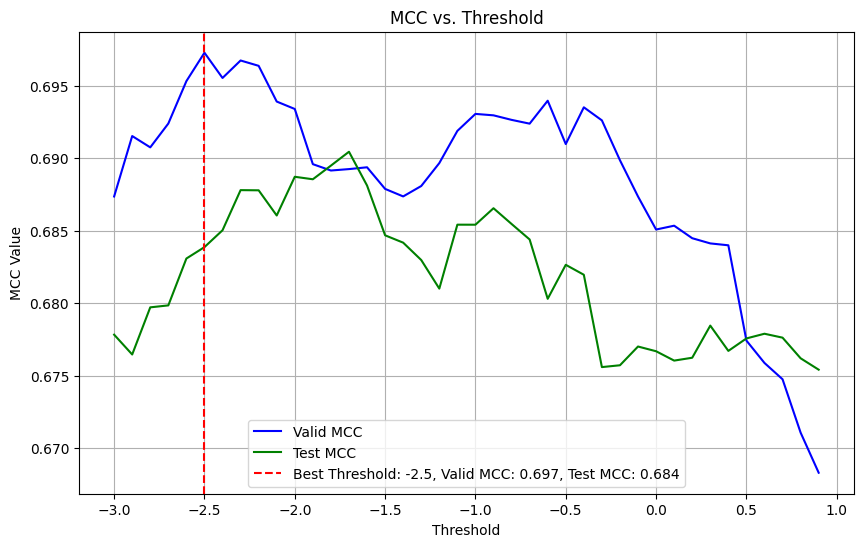

{'best_threshold': -2.4999999999999996,
 'valid_mcc': 0.6972750879721568,
 'sensitivity': 0.6858054226475279,
 'specificity': 0.9850161163864448,
 'accuracy': 0.9695192466545515,
 'precision': 0.7142857142857143,
 'mcc': 0.6838645868761727}

In [15]:
preds = get_preds_with_prefixes(['ab_me_90'], seed_start=0, seed_end=30)
df_valid, df_test = aggregate_preds(preds)

draw_hard_voting_threshold_chart(df_valid, df_test, start=-3, end=1, step=0.1, plot=True)